# Job Setup and Post-Processing for Nath & Thingbaijam (2012)

Mostly minor reformatting.

## Job Setup

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os
import glob
import codecs
import warnings
import numpy as np
import pandas as pd
%autoreload 2
import toolbox as tb

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

%autoreload 2
import oq_output.hazard_curve_converter as hcc
%autoreload 2
import oq_output.hazard_map_converter as hmc

In [3]:
nath_path = '../Data/nath2012probabilistic'
sites_table = os.path.join(nath_path, 'Table 3.csv')
df_table3 = pd.read_csv(sites_table, skiprows=1)
df_table3

,City,Latitude (°N),Longitude (°E),BIS,zone,GSHAP,Present,Other,Reference
0,Ahmedabad,23.03,72.61,0.08,III,0.05,0.11,0.10,Jaiswal and Sinha 2007†
1,Bangalore,12.98,77.58,0.05,II,0.05,0.11,0.10; 0.15,Jaiswal and Sinha 2007†; Anbazhagan et al. 2009
2,Bhuj,23.25,69.66,0.18,V,0.20,0.42,0.25; 0.20-0.70,Jaiswal and Sinha 2007†; Petersen et al. 2004‡
3,Chennai,13.00,80.18,0.08,III,0.05,0.12,0.089; 0.10,Menon et al. 2010; Jaiswal and Sinha 2007†
4,Dehradun,30.33,78.04,0.12,IV,0.30,0.47,0.45,Mahajan et al. 2010
5,Guwahati,26.18,91.73,0.18,V,0.30,0.66,0.50,Sharma and Malik 2006
6,Hyderabad,17.45,78.46,0.05,II,0.05,0.09,0.08,Jaiswal and Sinha 2007†
7,Imphal,24.78,93.94,0.18,V,0.45,0.68,0.50,Sharma and Malik 2006
8,Jabalpur,23.20,79.95,0.08,III,0.10,0.19,0.15,Jaiswal and Sinha 2007†
9,Kolkata,22.65,88.45,0.08,III,0.10,0.15,0.10,Jaiswal and Sinha 2007†


In [4]:
df_sites = df_table3[['Longitude (°E)', 'Latitude (°N)']]
sites_csv = 'NT2012_Table_3_lon_lat.csv'
print('sites_csv = %s' % sites_csv)
df_sites.to_csv(sites_csv, header=False, index=False, float_format='%g')

sites_csv = NT2012_Table_3_lon_lat.csv


In [5]:
map_imts = ['PGA','SA(0.2)','SA(1.0)']
map_tables = ['India_pga.csv','India_psa_pt2sec.csv','India_psa_1sec.csv']
map_table_list = [os.path.join(nath_path, item) for item in map_tables]
map_table_df_list = [pd.read_csv(file_name) for file_name in map_table_list]

In [6]:
df_map = map_table_df_list[0][['lon', 'lat']]
map_csv = 'NT2012_Figure_7_Indian_subcontinent_lon_lat.csv'
print('sites_csv = %s' % map_csv)
df_map.to_csv(map_csv, header=False, index=False, float_format='%g')

sites_csv = NT2012_Figure_7_Indian_subcontinent_lon_lat.csv


Given an occurrence rate $\lambda$ in a given time span $T_1$ the probability of one or more occurrences $P_1$ is

$P_1 = 1 - e ^{-\lambda T_1}$

so given a probability of exceedence, we can compute the rate 

$\lambda = \frac{-1}{T_1} \ln(1 - P_1)$

and work out the probability of exceedence for a different time period.

$P_2 = 1 - e ^{-\lambda T_2}$


In [7]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50  # years
rate = -np.log(1 - poes_nom)/T_nom  # per year
T_inv = 1.  # year
poes_inv = 1 - np.exp(-rate*T_inv)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]

print('investigation_time = %s' % str(T_inv))
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_inv]))
print(poe_labels)

investigation_time = 1.0
poes = 0.002105 0.00040397
['10% in 50 years', '2% in 50 years']


In [8]:
im_types = ['PGA', 'SA(0.2)', 'SA(1.0)']
periods = tb.logspace(0.005, 4, 3)
periods_string = ', '.join([str(T) for T in periods])

print('intensity_measure_types_and_levels = {%s}' 
      % ', '.join(['"%s": [%s]' % (im_type, periods_string) 
                   for im_type in im_types]))

intensity_measure_types_and_levels = {"PGA": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], "SA(0.2)": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], "SA(1.0)": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]}


In [9]:
# areal_only_no_fmd_uncertainty
n_gmpe_lt_rlzs = 3*3*2*2*3*2*3*3*2
print('n_gmpe_lt_rlzs = %d' % n_gmpe_lt_rlzs)
n_src_lt_rlzs = 1
print('n_src_lt_rlzs = %d' % n_src_lt_rlzs)
n_lt_rlzs = n_gmpe_lt_rlzs*n_src_lt_rlzs
print('n_lt_rlzs = %d' % n_lt_rlzs)
n_sites = len(df_table3)
print('n_sites = %d' % n_sites)
n_imt_iml = len(im_types)*periods.size
print('n_imt_iml = %d' % n_imt_iml)
n_curves = n_lt_rlzs*n_sites*n_imt_iml
print('n_curves = n_lt_rlzs*n_sites*n_imt_iml = %d*%d*%d = %d' %
     (n_lt_rlzs, n_sites, n_imt_iml, n_curves))
n_files = n_lt_rlzs*n_imt_iml
print('n_files = n_lt_rlzs*n_imt_iml = %d*%d = %d' %
     (n_lt_rlzs, n_imt_iml, n_files))

n_gmpe_lt_rlzs = 3888
n_src_lt_rlzs = 1
n_lt_rlzs = 3888
n_sites = 18
n_imt_iml = 27
n_curves = n_lt_rlzs*n_sites*n_imt_iml = 3888*18*27 = 1889568
n_files = n_lt_rlzs*n_imt_iml = 3888*27 = 104976


In [10]:
# areal_only_no_fmd_uncertainty_map
n_gmpe_lt_rlzs = 3*3*2*2*3*2*3*3*2
print('n_gmpe_lt_rlzs = %d' % n_gmpe_lt_rlzs)
n_src_lt_rlzs = 1
print('n_src_lt_rlzs = %d' % n_src_lt_rlzs)
n_lt_rlzs = n_gmpe_lt_rlzs*n_src_lt_rlzs
print('n_lt_rlzs = %d' % n_lt_rlzs)
n_sites = len(df_map)
print('n_sites = %d' % n_sites)
n_imt_iml = len(im_types)
print('n_imt_iml = %d' % n_imt_iml)
n_curves = n_lt_rlzs*n_sites*n_imt_iml
print('n_curves = n_lt_rlzs*n_sites*n_imt_iml = %d*%d*%d = %d' %
     (n_lt_rlzs, n_sites, n_imt_iml, n_curves))
n_files = n_lt_rlzs*n_imt_iml
print('n_files = n_lt_rlzs*n_imt_iml = %d*%d = %d' %
     (n_lt_rlzs, n_imt_iml, n_files))

n_gmpe_lt_rlzs = 3888
n_src_lt_rlzs = 1
n_lt_rlzs = 3888
n_sites = 8102
n_imt_iml = 3
n_curves = n_lt_rlzs*n_sites*n_imt_iml = 3888*8102*3 = 94501728
n_files = n_lt_rlzs*n_imt_iml = 3888*3 = 11664


## Post-Processing

In [11]:
CALC_ID = 111
export_dir = '../HazardOutputs'
export_path = os.path.join(os.path.abspath(export_dir), 'calc_%d' % CALC_ID)

exported_files = [os.path.join(dir_path, f)
    for dir_path, dirnames, files in os.walk(export_path)
    for f in files if f.endswith('.xml')]
exported_files
print export_path

/home/nick/Desktop/Individual Study/HazardOutputs/calc_111


In [12]:
subset_keys = ['hazard_curve-', 'mean']
output_subset = [item for item in exported_files if all(key in item for key in subset_keys)]
output_subset

['/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_curve/PGA/hazard_curve-mean.xml',
 '/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_curve/SA-0.2/hazard_curve-mean.xml',
 '/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_curve/SA-1.0/hazard_curve-mean.xml']

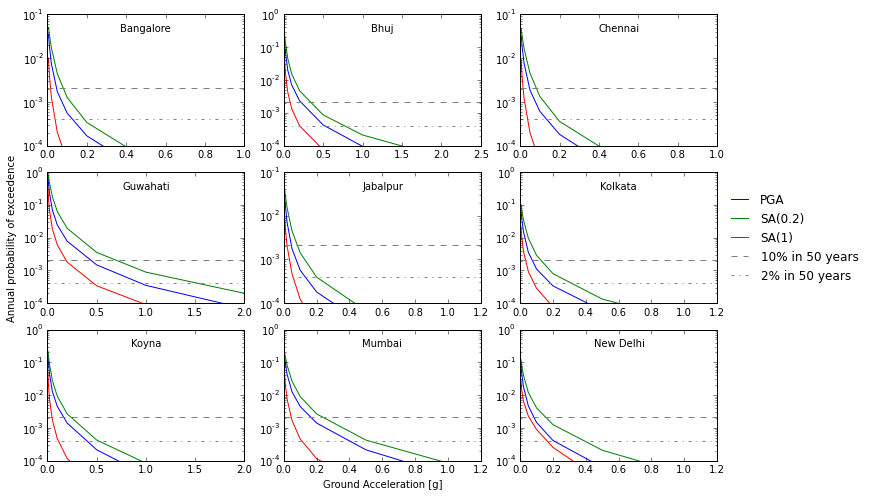

In [13]:
plot_cities = np.array([['Bangalore', 'Bhuj', 'Chennai'],
                        ['Guwahati', 'Jabalpur', 'Kolkata'],
                        ['Koyna', 'Mumbai', 'New Delhi']])
a_maxima = np.array([[1, 2.5, 1], [2, 1.2, 1.2], [2, 1.2, 1.2]])

fig, axes = plt.subplots(plot_cities.shape[0], plot_cities.shape[1], 
                         figsize=(12,8))

for file_name in output_subset:
    hcm = hcc.read_hazard_curves(file_name)
    label = os.path.split(file_name)[1]
    
    if hcm['investigation_time'] != T_inv:
        warnings.warn(
            'Investigation time %g instead of expected %g' %
            hcm['investigation_time'], T_inv, UserWarning)
    
    if hcm['imt'] == 'PGV':
        warnings.warn('IMT %s units not properly reflected in axis label.' % 
                      hcm['imt'], UserWarning)
        
    for row in hcm['curves']:
        lon, lat = row[:2]
        in_table3 = ((df_table3['Longitude (°E)'] == lon) & 
                     (df_table3['Latitude (°N)'] == lat))
        
        if any(in_table3):
            city = df_table3.loc[in_table3, 'City'].values[0]
        else:
            print('Unknown site %g°N %g°E. Ignoring ...', (lat, lon))
            continue
            
        if city in plot_cities:
            ax = axes[plot_cities == city][0]
            poes = row[2:]
            ax.semilogy(hcm["imls"], poes, label=hcm['imt'])

for ax, city, a_max in zip(axes.ravel(), plot_cities.ravel(), a_maxima.ravel()):
    ax.set_xlim((0, a_max))
    ax.set_ylim((1e-4, ax.get_ylim()[1]))
    for prob, label, linestyle in zip(poes_inv, poe_labels, ['--', '-.', ':']):
        ax.axhline(prob, label=label, color='0.5', linestyle=linestyle)
    anchored_text = AnchoredText(city, loc=tb.LOC_CODE['upper center'], frameon=False)
    ax.add_artist(anchored_text)

axes[1,0].set_ylabel('Annual probability of exceedence')
axes[-1,1].set_xlabel('Ground Acceleration [g]')
axes[1,-1].legend(loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
fig.savefig('Figure_6_Reproduced.pdf', dpi=600)

In [14]:
subset_keys = ['hazard_map', 'mean']
output_subset = [item for item in exported_files if all(key in item for key in subset_keys)]
output_subset

['/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_map/PGA/hazard_map-poe_0.00210499170414-mean.xml',
 '/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_map/SA-0.2/hazard_map-poe_0.00210499170414-mean.xml',
 '/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_map/SA-1.0/hazard_map-poe_0.00210499170414-mean.xml']

In [15]:
map_csv_list = [hmc.save_hazard_map_to_csv(file_name, force_overwrite=True) for file_name in output_subset]

In [16]:
map_csv_list

['/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_map/PGA/hazard_map-poe_0.00210499170414-mean.csv',
 '/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_map/SA-0.2/hazard_map-poe_0.00210499170414-mean.csv',
 '/home/nick/Desktop/Individual Study/HazardOutputs/calc_111/hazard_map/SA-1.0/hazard_map-poe_0.00210499170414-mean.csv']

In [17]:
df_pga = pd.read_csv(map_csv_list[0], header=1)

df_compare = pd.merge(df_table3, df_pga, left_on = 'Longitude (°E)', right_on = 'lon')
drop_cols = ['BIS','zone','GSHAP','Other','Reference','lon','lat']
df_compare.drop(drop_cols, axis=1, inplace=True)
df_compare.rename(columns={'Present':'NT2012', 'iml': 'A2016'}, inplace=True)
df_compare['Error (%)'] = (100*(df_compare['A2016']/df_compare['NT2012'] - 1)).round(1)
df_compare.sort(columns='NT2012')

,City,Latitude (°N),Longitude (°E),NT2012,A2016,Error (%)
17,Thiruvananthapuram,8.50,76.95,0.07,0.042818,-38.8
6,Hyderabad,17.45,78.46,0.09,0.040303,-55.2
0,Ahmedabad,23.03,72.61,0.11,0.071280,-35.2
1,Bangalore,12.98,77.58,0.11,0.043922,-60.1
3,Chennai,13.00,80.18,0.12,0.046246,-61.5
13,Patna,25.60,85.10,0.13,0.095028,-26.9
9,Kolkata,22.65,88.45,0.15,0.068336,-54.4
11,Mumbai,19.11,72.85,0.16,0.157534,-1.5
8,Jabalpur,23.20,79.95,0.19,0.044386,-76.6
12,New Delhi,28.56,77.11,0.24,0.080913,-66.3


In [24]:
df_compare['Error (%)'].describe()

count    18.000000
mean    -47.805556
std      18.224175
min     -76.600000
25%     -61.150000
50%     -51.550000
75%     -38.050000
max      -1.500000
Name: Error (%), dtype: float64

In [19]:
with codecs.open('first_results.tex', 'w', 'utf-8') as file_object:
    df_compare.to_latex(file_object)

In [20]:
df_compare.to_csv('Table_3_Reproduced.csv')